
Menulis 12 film rekomendasi ke file 'film_rekomendasi.csv'...
Selesai menyimpan file.


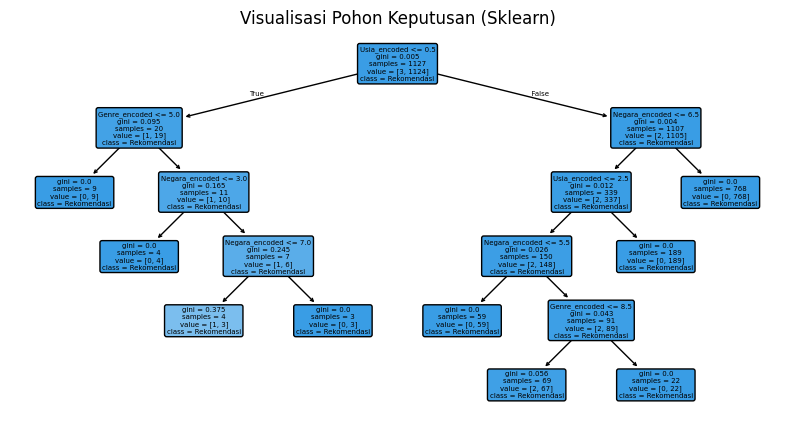


 Aturan Pohon Keputusan dalam Bahasa Natural:

 Visualisasi Custom Pohon Keputusan (NetworkX):


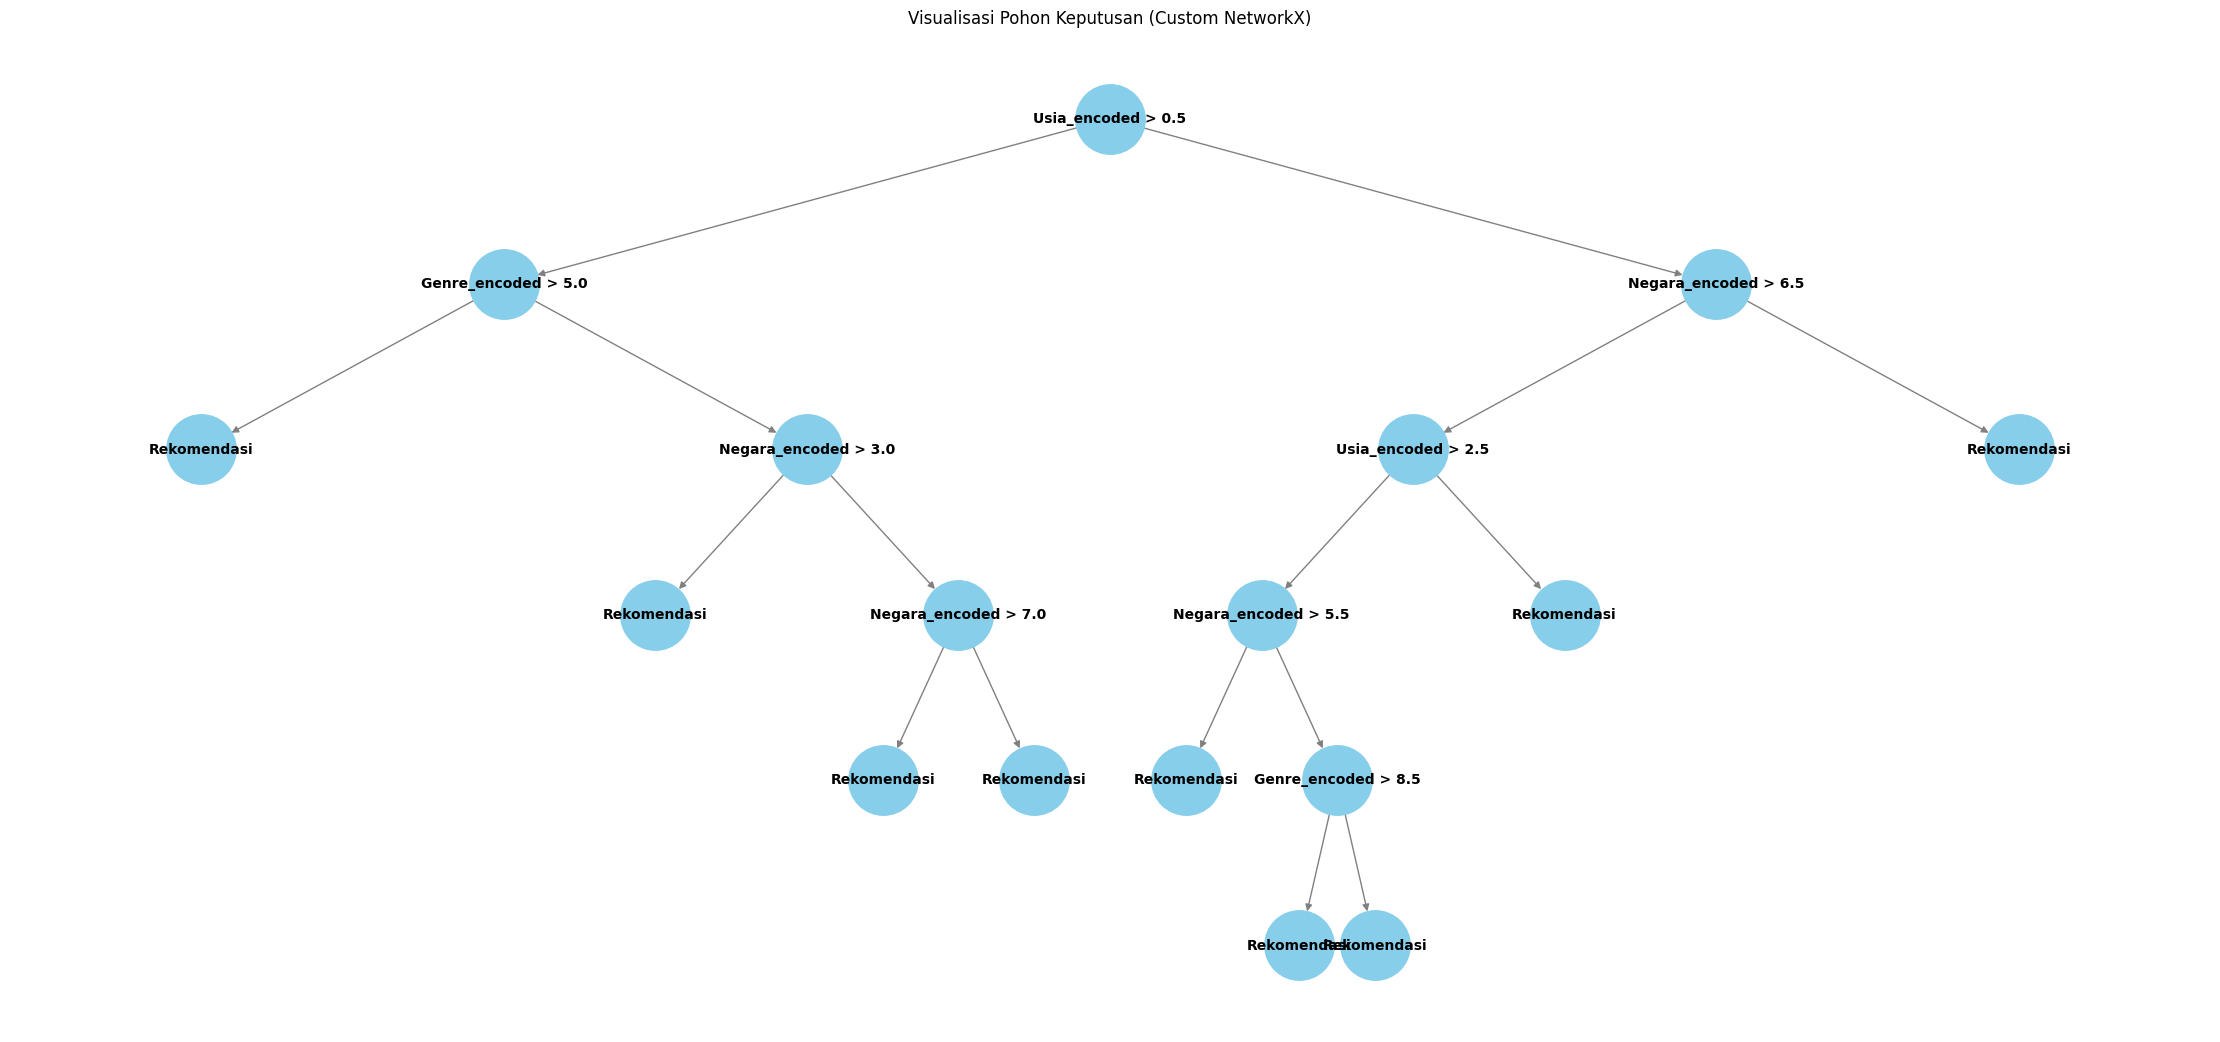

In [46]:
import csv
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import networkx as nx


def load_and_clean_data(filepath):
    rows = []
    with open(filepath, encoding="utf-8") as f:
        reader = csv.reader(f)
        for row in reader:
            if len(row) == 6:
                rows.append(row)

    df = pd.DataFrame(rows, columns=['Judul Film', 'Tahun', 'Negara', 'Rating IMDb', 'Usia Tontonan', 'Genre'])
    df['Rating IMDb'] = df['Rating IMDb'].astype(str).str.replace(',', '.', regex=False)
    df['Rating IMDb'] = pd.to_numeric(df['Rating IMDb'], errors='coerce')
    df.dropna(subset=['Rating IMDb'], inplace=True)

    df = df[~df['Genre'].astype(str).str.match(r'^\d+(\.\d+)?$')]
    df = df[df['Usia Tontonan'].astype(str).str.contains(r'\d+\+|Semua', regex=True)]
    df = df[~df['Genre'].str.lower().str.contains('petualangann')]
    df = df[~df['Usia Tontonan'].str.lower().str.contains('semua umur')]

    df['rekomendasi'] = df['Rating IMDb'].apply(lambda x: 1 if x > 5.0 else 0)
    return df

def encode_features(df):
    df['Genre'] = df['Genre'].astype('category')
    df['Usia Tontonan'] = df['Usia Tontonan'].astype('category')
    df['Negara'] = df['Negara'].astype('category')

    df['Genre_encoded'] = df['Genre'].cat.codes
    df['Usia_encoded'] = df['Usia Tontonan'].cat.codes
    df['Negara_encoded'] = df['Negara'].cat.codes

    categories = {
        'Genre': df['Genre'].cat.categories,
        'Usia Tontonan': df['Usia Tontonan'].cat.categories,
        'Negara': df['Negara'].cat.categories
    }

    return df, categories

def encode_features_with_categories(df, categories):
    df['Genre'] = pd.Categorical(df['Genre'], categories=categories['Genre'])
    df['Usia Tontonan'] = pd.Categorical(df['Usia Tontonan'], categories=categories['Usia Tontonan'])
    df['Negara'] = pd.Categorical(df['Negara'], categories=categories['Negara'])

    df['Genre_encoded'] = df['Genre'].cat.codes
    df['Usia_encoded'] = df['Usia Tontonan'].cat.codes
    df['Negara_encoded'] = df['Negara'].cat.codes

    return df


def train_model(df):
    X = df[['Genre_encoded', 'Usia_encoded', 'Negara_encoded']]
    y = df['rekomendasi']
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)
    model = DecisionTreeClassifier(max_depth=5, random_state=0)
    model.fit(X_train, y_train)
    return model


def dapatkan_input_user_otomatis():
    genre = 'petualangan'         
    usia = '17+'            
    negara = 'korea'    
    genre = genre.strip().lower()
    usia = usia.strip().lower()
    negara = negara.strip().lower()

    return genre, usia, negara


def filter_dan_prediksi_simpan_csv(df, model, genre_input, usia_input, negara_input, output_csv, categories):
    film_terfilter = df[
        (df['Genre'].str.lower() == genre_input) &
        (df['Usia Tontonan'].str.lower() == usia_input) &
        (df['Negara'].str.lower() == negara_input)
    ].copy()

    if film_terfilter.empty:
        print("\nTidak ada film yang cocok dengan filter tersebut.")
        return

    film_terfilter = encode_features_with_categories(film_terfilter, categories)
    X_film = film_terfilter[['Genre_encoded', 'Usia_encoded', 'Negara_encoded']]
    film_terfilter['Prediksi'] = model.predict(X_film)

    rekom = film_terfilter[film_terfilter['Prediksi'] == 1]

    if rekom.empty:
        print("\nTidak ada film yang direkomendasikan berdasarkan model.")
    else:
        print(f"\nMenulis {len(rekom)} film rekomendasi ke file '{output_csv}'...")
        rekom.to_csv(output_csv, index=False, encoding='utf-8-sig')
        print("Selesai menyimpan file.")


def tampilkan_pohon_visual(model, feature_names):
    plt.figure(figsize=(10, 5))
    plot_tree(model,
              feature_names=feature_names,
              class_names=['Tidak Rekomendasi', 'Rekomendasi'],
              filled=True,
              rounded=True,
              fontsize=5)
    plt.title("Visualisasi Pohon Keputusan (Sklearn)")
    plt.show()


def cetak_aturan_natural(model, df):
    genre_map = dict(enumerate(df['Genre'].astype('category').cat.categories))
    usia_map = dict(enumerate(df['Usia Tontonan'].astype('category').cat.categories))
    negara_map = dict(enumerate(df['Negara'].astype('category').cat.categories))

    tree_ = model.tree_
    feature_names = ['Genre_encoded', 'Usia_encoded', 'Negara_encoded']
    features = [feature_names[i] if i != -2 else "undefined!" for i in tree_.feature]

    def traverse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != -2:
            name = features[node]
            threshold = tree_.threshold[node]
            label = name.replace('_encoded', '')

            mapping = {
                'Genre': genre_map,
                'Usia': usia_map,
                'Negara': negara_map
            }.get(label.capitalize(), {})

            kiri = mapping.get(int(threshold), f"kode ≤ {int(threshold)}")
            kanan = mapping.get(int(threshold) + 1, f"kode > {int(threshold)}")

            print(f"{indent}Jika {label.capitalize()} ≤ \"{kiri}\":")
            traverse(tree_.children_left[node], depth + 1)
            print(f"{indent}Jika {label.capitalize()} > \"{kanan}\":")
            traverse(tree_.children_right[node], depth + 1)
        else:
            value = tree_.value[node]
            prediksi = int(value[0][1] > value[0][0])
            print(f"{indent}→ Prediksi: {'Rekomendasi' if prediksi == 1 else 'Tidak Rekomendasi'}")


class Node:
    def __init__(self, attribute=None, threshold=None, left=None, right=None, result=None, is_greater=False):
        self.attribute = attribute
        self.threshold = threshold
        self.left = left
        self.right = right
        self.result = result
        self.is_greater = is_greater

    def is_leaf(self):
        return self.result is not None

def sklearn_tree_to_node(model, feature_names):
    tree_ = model.tree_

    def recurse(node_index):
        if tree_.feature[node_index] != -2:
            feature = feature_names[tree_.feature[node_index]]
            threshold = tree_.threshold[node_index]

            left = recurse(tree_.children_left[node_index])
            right = recurse(tree_.children_right[node_index])
            return Node(attribute=feature, threshold=threshold, left=left, right=right, is_greater=True)
        else:
            value = tree_.value[node_index]
            result = 'Rekomendasi' if value[0][1] > value[0][0] else 'Tidak'
            return Node(result=result)

    return recurse(0)

def get_node_label(node):
    if node.is_leaf():
        return node.result
    else:
        return f"{node.attribute} > {node.threshold:.1f}"

def hierarchy_pos(G, root, width=1.0, vert_gap=0.2, vert_loc=0, xcenter=0.5):
    pos = {}
    def _hierarchy_pos(G, node, left, right, vert_loc, xcenter):
        pos[node] = (xcenter, vert_loc)
        neighbors = list(G.successors(node))
        if len(neighbors) == 2:
            l, r = neighbors
            dx = (right - left) / 2
            pos.update(_hierarchy_pos(G, l, left, left + dx, vert_loc - vert_gap, left + dx / 2))
            pos.update(_hierarchy_pos(G, r, left + dx, right, vert_loc - vert_gap, left + 3 * dx / 2))
        elif len(neighbors) == 1:
            pos.update(_hierarchy_pos(G, neighbors[0], left, right, vert_loc - vert_gap, xcenter))
        return pos
    return _hierarchy_pos(G, root, 0, width, vert_loc, xcenter)

def visualize_tree(node):
    G = nx.DiGraph()
    node_id = [0]

    def add_nodes_edges(current_node, parent=None):
        if current_node is None:
            return
        curr_id = node_id[0]
        node_id[0] += 1
        label = get_node_label(current_node)
        G.add_node(curr_id, label=label)
        if parent is not None:
            G.add_edge(parent, curr_id)
        add_nodes_edges(current_node.left, curr_id)
        add_nodes_edges(current_node.right, curr_id)
        return curr_id

    add_nodes_edges(node)
    labels = nx.get_node_attributes(G, 'label')
    pos = hierarchy_pos(G, 0)
    plt.figure(figsize=(22, 10))
    nx.draw(G, pos, with_labels=True, labels=labels,
            node_size=2500, node_color="skyblue", font_size=10,
            font_weight='bold', edge_color='gray')
    plt.title("Visualisasi Pohon Keputusan (Custom NetworkX)")
    plt.show()


def main():
    filepath = "LIST_GENRE_FILM_SDA_JOSss.csv"
    df = load_and_clean_data(filepath)

    df, categories = encode_features(df)  
    model = train_model(df)

    genre_input, usia_input, negara_input = dapatkan_input_user_otomatis()
    output_csv = "film_rekomendasi.csv"
    filter_dan_prediksi_simpan_csv(df, model, genre_input, usia_input, negara_input, output_csv, categories)

    feature_names = ['Genre_encoded', 'Usia_encoded', 'Negara_encoded']
    tampilkan_pohon_visual(model, feature_names)

    print("\n Aturan Pohon Keputusan dalam Bahasa Natural:")
    cetak_aturan_natural(model, df)

    print("\n Visualisasi Custom Pohon Keputusan (NetworkX):")
    root_node = sklearn_tree_to_node(model, feature_names)
    visualize_tree(root_node)


if __name__ == "__main__":
    main()